In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Introduction and Quick Cleaning

In [48]:
df = pd.read_csv("data/diamonds.csv", index_col = 'Unnamed: 0')

In [49]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
df.shape

(53940, 10)

In [5]:
df.drop((df[(df['x'] == 0 ) | (df['y'] == 0) | (df['z'] == 0)].index), axis =0, inplace = True)

In [6]:
df['v'] = df['x'] * df['y'] * df['z']

In [11]:
df.drop(['x','y','z'], axis = 1, inplace = True)

# Visualizing

In [12]:
dia_sit = df['cut'].value_counts()

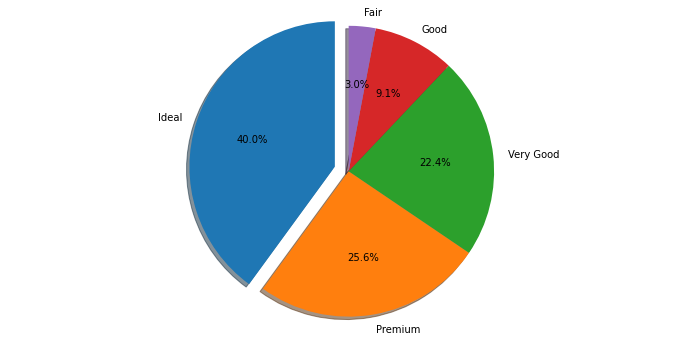

In [13]:
fig1, ax1 = plt.subplots(figsize = (12,6))
ax1.pie(dia_sit.values,explode = [0.1,0,0,0,0],  labels = dia_sit.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

<AxesSubplot:xlabel='price', ylabel='depth'>

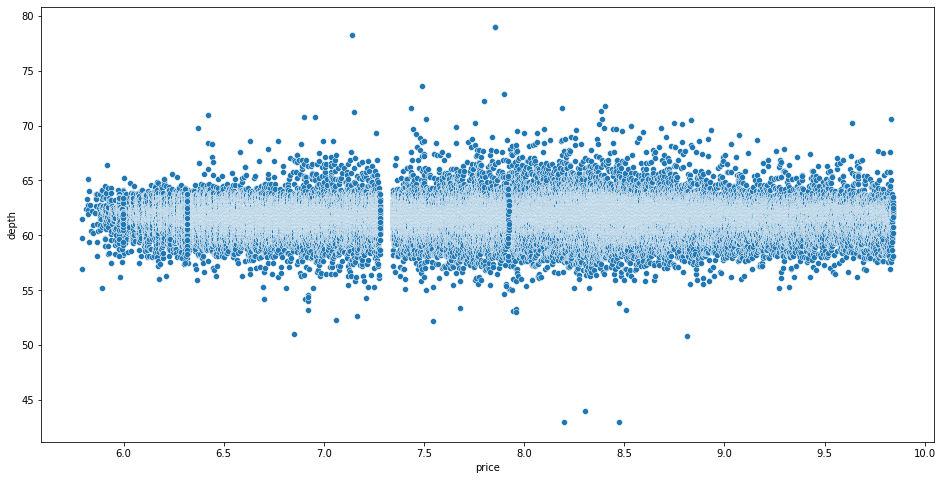

In [14]:
plt.figure(figsize = (16,8))
sns.scatterplot( x = np.log1p(df['price']), y = df['depth'])


<AxesSubplot:xlabel='price', ylabel='table'>

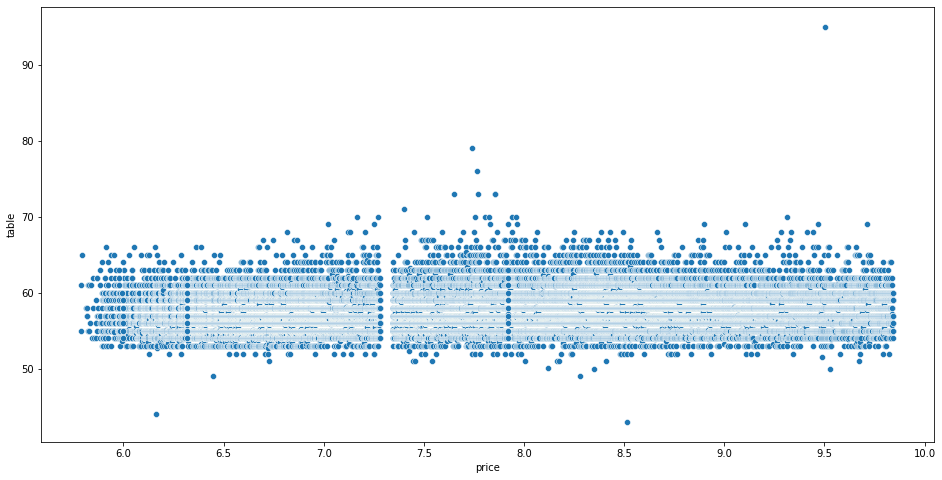

In [15]:
plt.figure(figsize = (16,8))
sns.scatterplot(x = np.log1p(df['price']), y = df['table'])


In [16]:
cla_price = df.groupby('clarity')['price'].mean()

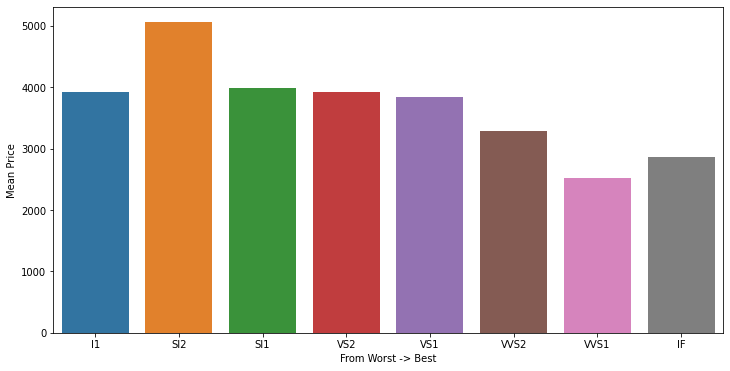

In [17]:
plt.figure(figsize = (12,6))

sns.barplot(x = cla_price.index, y = cla_price.values , order = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"])
plt.xlabel('From Worst -> Best')
plt.ylabel('Mean Price')
plt.show()

In [18]:
col_price = df.groupby('color')['price'].mean()
col_price.head()

color
D    3168.106436
E    3076.752475
F    3725.080205
G    3996.876551
H    4480.942155
Name: price, dtype: float64

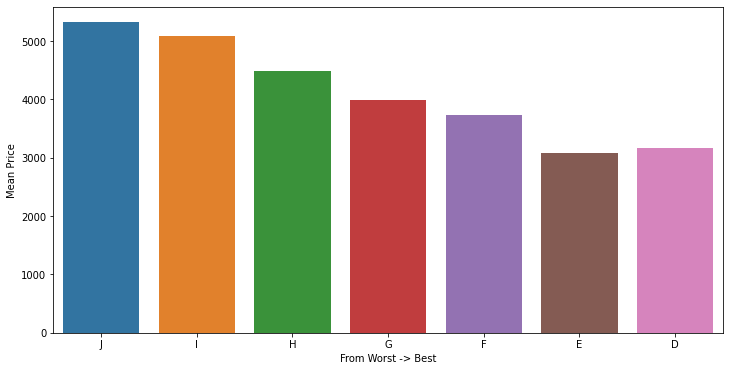

In [19]:
plt.figure(figsize = (12,6))

sns.barplot(x = col_price.index, y = col_price.values , order = list(reversed(col_price.index)))
plt.xlabel('From Worst -> Best')
plt.ylabel('Mean Price')
plt.show()

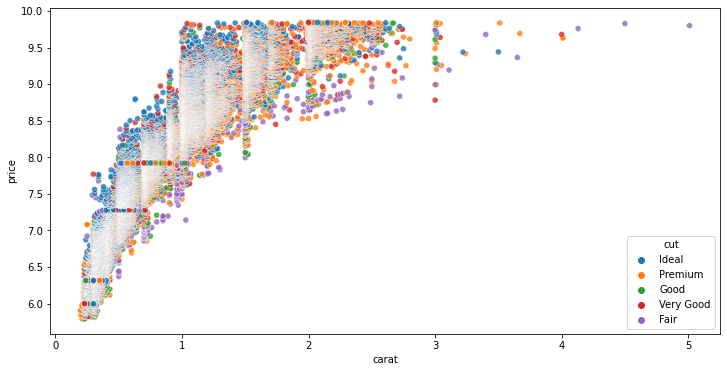

In [20]:
plt.figure(figsize = (12,6))
sns.scatterplot(x = df['carat'], y= np.log1p(df['price']), hue = df['cut'], alpha = 0.8)
plt.show()

In [21]:
cut_price = df.groupby('cut')['price'].mean()

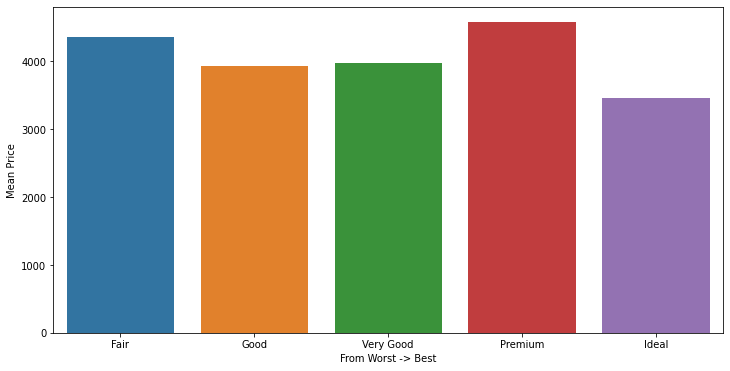

In [22]:
plt.figure(figsize = (12,6))

sns.barplot(x = cut_price.index, y = cut_price.values, order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'] )
plt.xlabel('From Worst -> Best')
plt.ylabel('Mean Price')
plt.show()

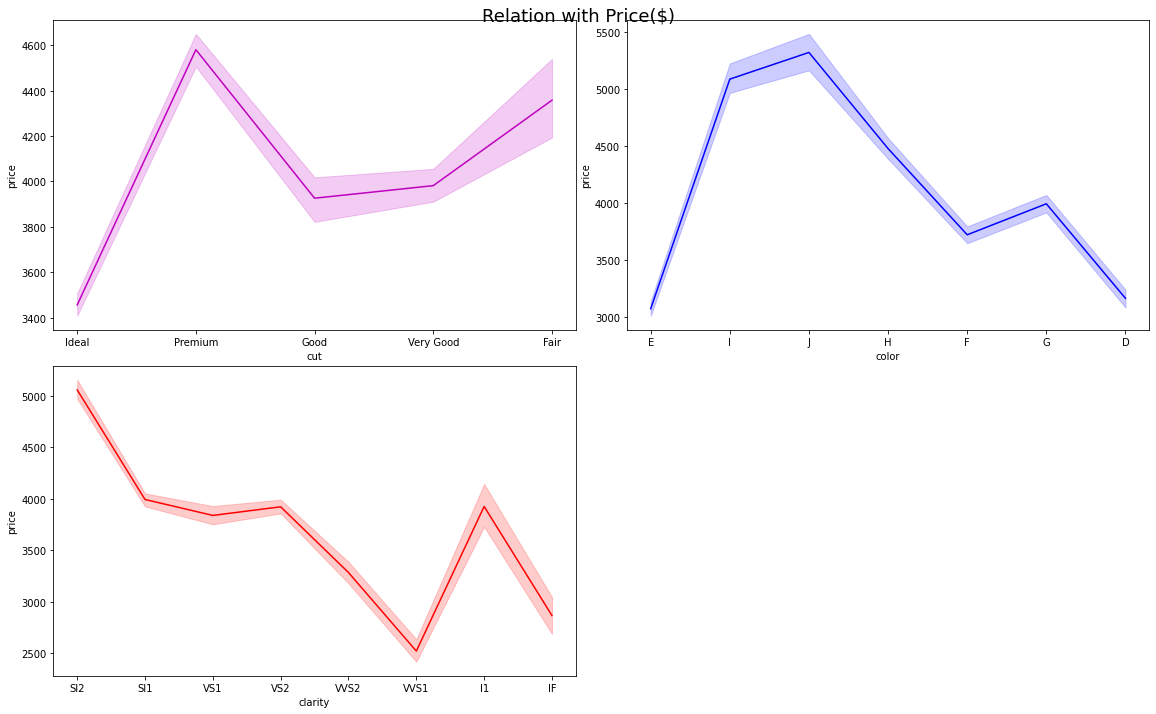

In [23]:
plt.figure(figsize=(16,10))

plt.subplot(2,2,1)
sns.lineplot(data=df,x='cut',y='price',color='m')

plt.subplot(2,2,2)
sns.lineplot(data=df,x='color',y='price',color='blue')

plt.subplot(2,2,3)
sns.lineplot(data=df,x='clarity',y='price',color='red')

plt.suptitle("Relation with Price($)",fontsize=18)

plt.tight_layout(pad=0.5)
plt.show()

# Preparing for Machine Learning

In [31]:
df.head()

,carat,cut,color,clarity,depth,table,price,v
1,0.23,5,E,SI2,61.5,55.0,326,38.202030
2,0.21,4,E,SI1,59.8,61.0,326,34.505856
3,0.23,2,E,VS1,56.9,65.0,327,38.076885
4,0.29,4,I,VS2,62.4,58.0,334,46.724580
5,0.31,2,J,SI2,63.3,58.0,335,51.917250


In [29]:
cut_quality = {'Fair' : "1"cut_class_dict = {'Fair': 1, 'Good': 2, 'Very Good': 3, 'Premium': 4, 'Ideal': 5, }, "Good" :"2", "Very Good" : "3", "Premium" : 4 , "Ideal" : 5}

In [50]:
df['cut'] = df['cut'].map(cut_quality)

In [52]:
df['cut'] = df['cut'].astype(int)

In [33]:
df['color'].value_counts().index

Index(['G', 'E', 'F', 'H', 'D', 'I', 'J'], dtype='object')

In [34]:
color_dict     = {'J': 1, 'I': 2, 'H': 3, 'G': 4, 'F': 5, 'E': 5,'D': 5,}

In [35]:
df['color'] = df['color'].map(color_dict)

In [36]:
df['color'] = df['color'].astype(int)

In [37]:
clarity_qual = {x:str(y) for x,y in zip(["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"], range(1,9))}

In [38]:
df['clarity'] = df['clarity'].map(clarity_qual).astype(int)

In [39]:
df.head()

,carat,cut,color,clarity,depth,table,price,v
1,0.23,5,5,2,61.5,55.0,326,38.202030
2,0.21,4,5,3,59.8,61.0,326,34.505856
3,0.23,2,5,5,56.9,65.0,327,38.076885
4,0.29,4,2,4,62.4,58.0,334,46.724580
5,0.31,2,1,2,63.3,58.0,335,51.917250


# Model

In [40]:
X = df.drop('price', axis = 1)

In [41]:
y= df['price']
X_train, X_test, y_train, y_test =train_test_split(X,y , test_size  = 0.2, random_state = 42)

In [42]:
lr = LinearRegression()

In [43]:
lr.fit(X_train, y_train)

LinearRegression()

In [44]:
prediction = lr.predict(X_test)

In [45]:
print(mean_squared_error(prediction, y_test))

1400956.7492719775
